# Demo of StarPose
## Setup/Download Dependencies

In [ ]:
## Install StarDist and CSbDeep
!pip install csbdeep
!pip install stardist
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.

In [ ]:
## Bunch of libraries to run StarDist

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

import time, os, sys
from urllib.parse import urlparse
import matplotlib as mpl
from cellpose import utils, io

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [ ]:
## Loading pretrained models and such things for stardist
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


## Exploring how to Train StarDist Model

In [ ]:
## The following is part of their demo code, so here they are getting
## their training images
X = sorted(glob('data/dsb2018/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [ ]:
## now they are training demo model
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_demo' for 'StarDist2D'.
5298331/5298331 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


In [ ]:
## they apply normalization to the images, get predictions for labels
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)
print(img.shape)

(360, 360)


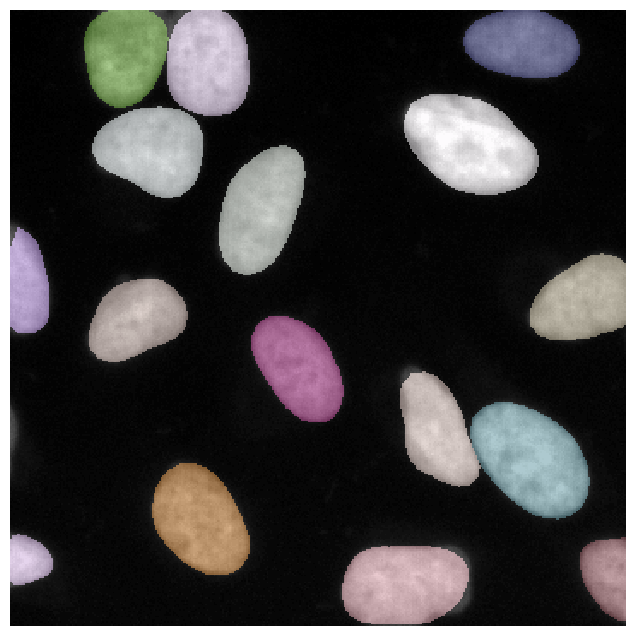

In [ ]:
## show results
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

In [ ]:
## helper function for stardist, they are now using 'details'
## to show the centers of each cell and the point's associated
## starconvex rays
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

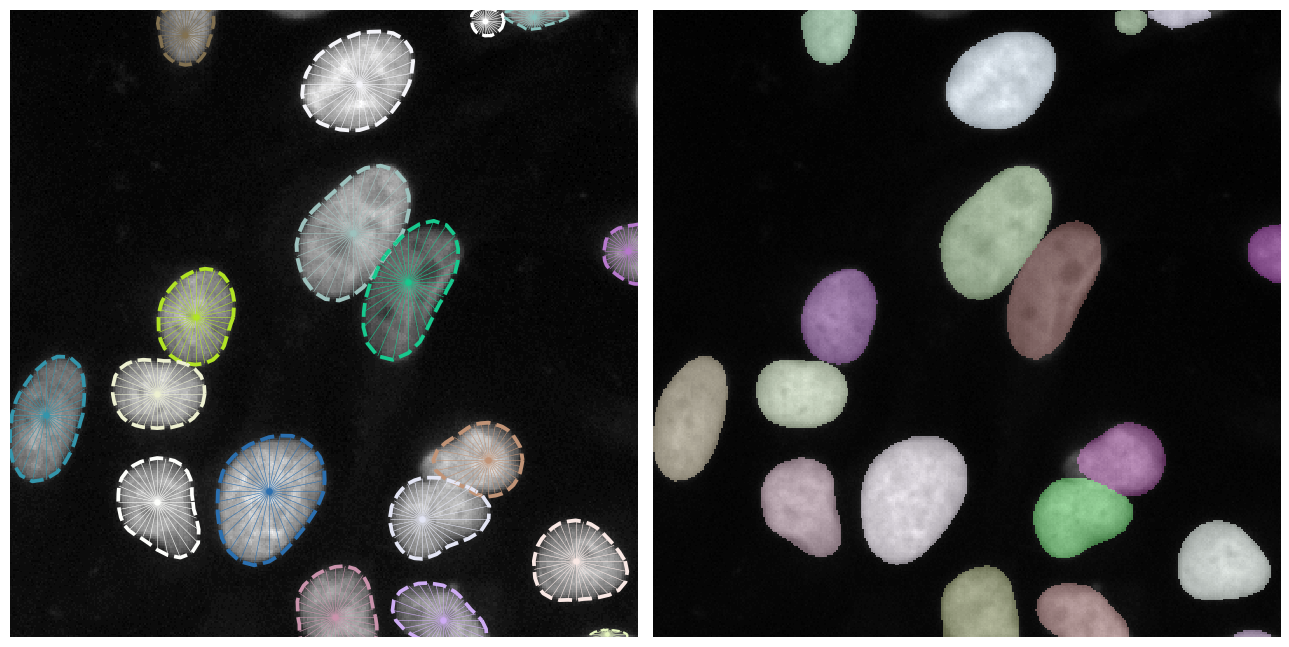

In [ ]:
## their model results, visualized
example(model, 42)

## Looking at StarDist Paper's Original Model

In [ ]:
## now we load the model used in their paper
model_paper = StarDist2D.from_pretrained('2D_paper_dsb2018')

Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


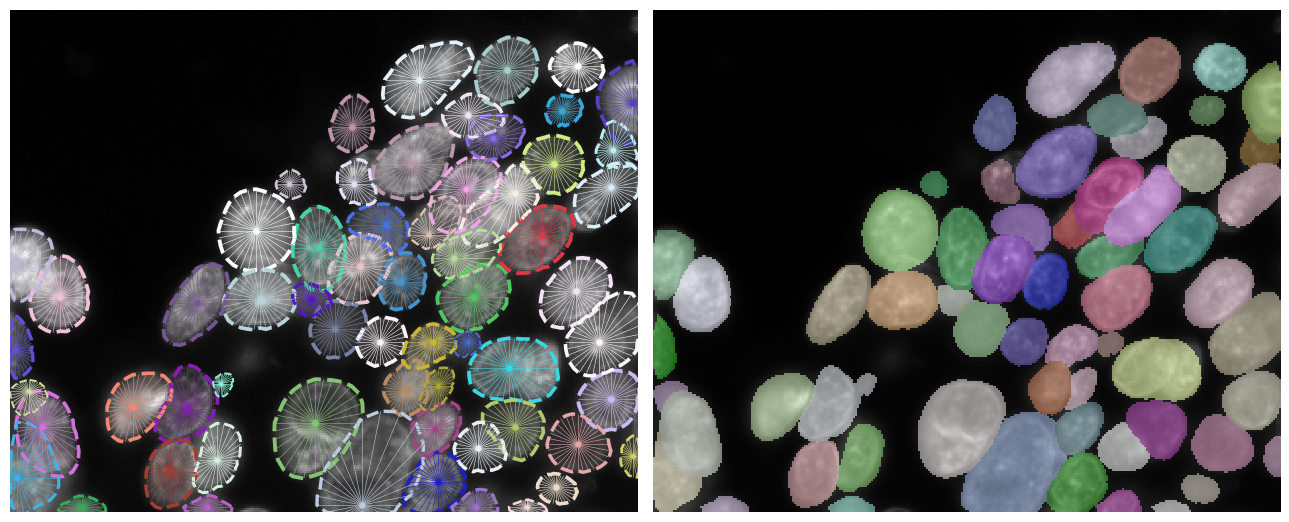

In [ ]:
## again showing results of how the model does
example(model_paper, 29)

### Convert Input Image to Binary Format - This is where our code begins!

In [441]:
from PIL import Image
import numpy as np


## I put this function here to take an image and make it binary
## it also ensures the image values are in the range [0, 255]
def binary_threshold_and_bw(image_path, threshold):
    """
    Apply binary thresholding to the image and convert it to black and white.

    Args:
    - image_path (str): Path to the input image file.
    - threshold (int): Threshold value for binarization.

    Returns:
    - bw_image (np.ndarray): Black and white image as a NumPy array.
    """
    # Load the image file
    image = Image.open(image_path)

    # Convert the image to grayscale
    grayscale_image = image.convert('L')

    # Convert the grayscale image to a NumPy array
    image_array = np.array(grayscale_image)

    # Apply binary thresholding
    thresholded_image = np.where(image_array >= threshold, 0, 255)

    # Ensure values are within the range [0, 255]
    thresholded_image = np.clip(thresholded_image, 0, 255)

    # Convert the datatype to ensure maximum value is 255
    thresholded_image = thresholded_image.astype(np.uint8)

    return thresholded_image


In [580]:
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter

## code that runs the above function and normalization on a test image
## we use the model used in stardist's paper to get the predictions
image_path = "combined_worm10.png"
image = Image.open(image_path)
shape_for_fill_holes = (np.array(image).shape[0], np.array(image).shape[1])
thresholded_image = binary_threshold_and_bw("combined_worm10.png", 128)

normalized_X16 = normalize(thresholded_image, 1, 99.8, axis=axis_norm)

labels, details = model_paper.predict_instances(normalized_X16)
output = model_paper._predict_sparse_generator(normalized_X16)
first_prediction = next(output)
first_pixels = first_prediction[2]
print(details['prob'].shape)

(94,)


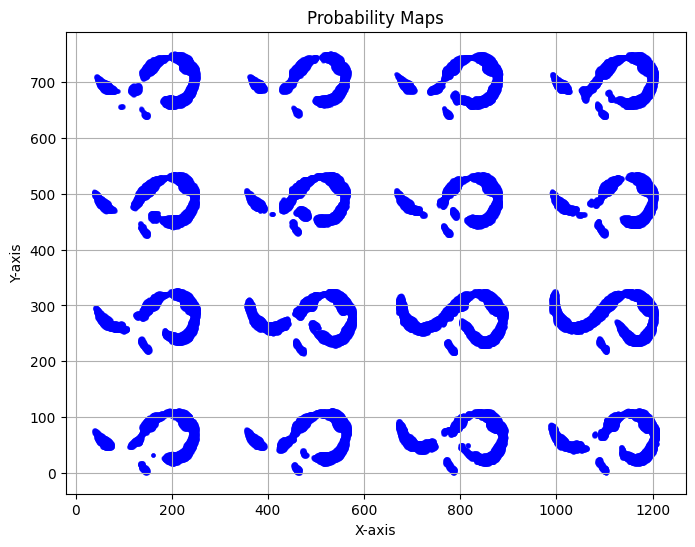

In [581]:
## this is a visualization of the probability maps that stardist gave
## there are some problems with continuity, which we now try to address
x = first_pixels[:, 1]
initial_y_vals = first_pixels[:, 0]
y = [initial_y_vals.max() - value for value in initial_y_vals]
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=5, c='blue', alpha=0.5)  # Adjust marker size and color as needed
plt.title('Probability Maps')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

### Apply Dilation to Create Blobs of Interest

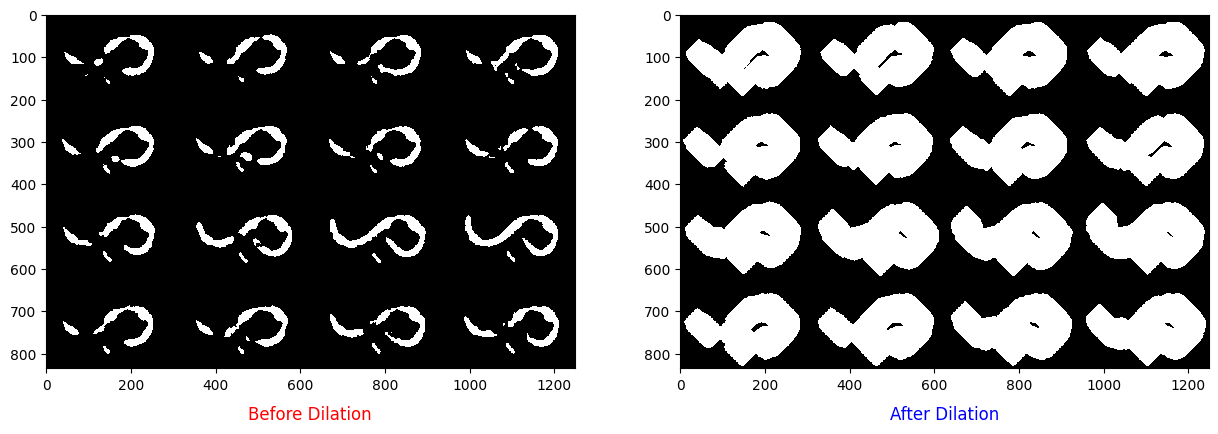

In [582]:
from scipy import ndimage
import numpy as np

## here we first convert the probability maps into a binary image
probability_mask = np.zeros_like(np.array(thresholded_image))

for coords in first_pixels:
  y, x = coords
  probability_mask[y, x] = 1

## now, we apply dilation to make connections
new_probs = ndimage.binary_dilation(probability_mask, iterations=30).astype(int)
f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].set_xlabel('Before Dilation', labelpad=10, fontsize=12, color='red')
axarr[1].set_xlabel('After Dilation', labelpad=10, fontsize=12, color='blue')
axarr[0].imshow(probability_mask, cmap='gray')
axarr[1].imshow(new_probs, cmap='gray')

### Use Blobs of Interest to Correct Cellpose Segmentation Predictions

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
160


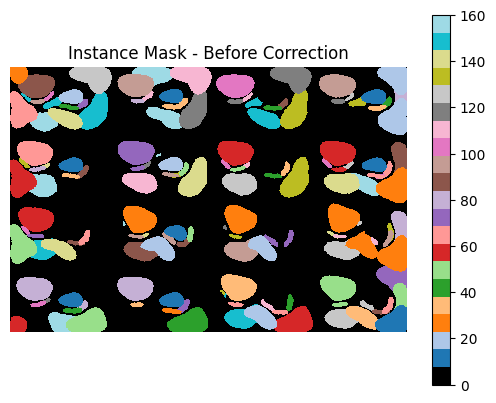

In [583]:
from matplotlib.colors import ListedColormap
from cellpose import models, io
from csbdeep.utils import normalize

# get prediction from fine-tuned model (use 'model_elegan' or 'cellpose_1714095580.9233449')

# this is the code used to evaluate the Cellpose and finetuned models
# model = models.CellposeModel(pretrained_model='model_elegan')
# model = models.Cellpose(model_type='cyto3')
# mask_array, flows, styles, diams = model.eval(np.array(image), diameter=None, channels=[0, 0])

# this code is for testing stardist
image = Image.open(image_path)

# Convert the image to grayscale
grayscale_image = image.convert('L')

# Convert the grayscale image to a NumPy array
image_array = np.array(grayscale_image)
mask_array, details = model_paper.predict_instances(normalize(image_array))
print(labels)

before_correction = np.copy(mask_array)

# Now, the goal is to combine segmentations that fall under the same blob from above
colors = list(plt.cm.tab20.colors)

# Create a colormap with black for 0 and distinct colors for other instance IDs
custom_cmap = ListedColormap(['black'] + colors)

print(mask_array.max())
plt.imshow(mask_array, cmap=custom_cmap)
plt.colorbar()  # Add a colorbar to show the mapping of instance IDs to colors
plt.title('Instance Mask - Before Correction')
plt.axis('off')  # Turn off axis
plt.show()

Overlap detected
merged value: 17
[ 17  43  65  76  90  98 105 124 142 148 150 151 154]
Overlap detected
merged value: 14
[ 14  34  38  83  96 109 113 121 156 160]
Overlap detected
merged value: 5
[  5  41  89 102 107 117 120 130 146 147]
Overlap detected
merged value: 8
[  8  18  22  32  44  77  92 118 128 134]
Overlap detected
merged value: 15
[ 15  36  54  66  82  84 137 139 158]
Overlap detected
merged value: 16
[ 16  48  72  73  95 108 116 136 144 157]
Overlap detected
merged value: 6
[  6  35  40  50  59 106 110 123 133]
Overlap detected
merged value: 9
[  9  26  58  60  64  68  85 100 104 129 143 159]
Overlap detected
merged value: 1
[  1  53  57  63  69  87 103 140 145]
Overlap detected
merged value: 10
[ 10  20  30  52  88  91  97  99 138 153]
Overlap detected
merged value: 7
[  7  19  28  74  75  94 119 135]
Overlap detected
merged value: 4
[  4  23  25  27  80  93 111 114 122 126 131 141]
Overlap detected
merged value: 11
[ 11  39  47  78  79 101 115 155]
Overlap detected
me

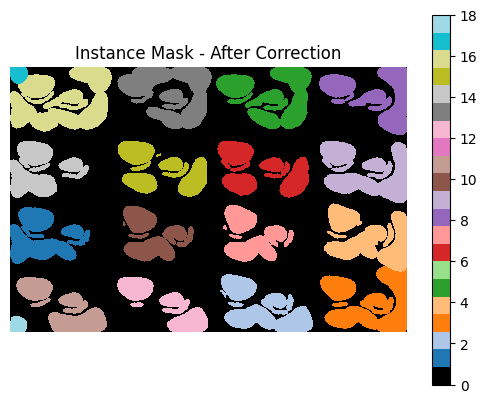

In [584]:
# get connected components
labels, num_features = ndimage.label(new_probs)

# Iterate over each connected component
for label in range(1, num_features+1):
    # Mask for the connected component
    component_mask = (labels == label)

    # Find instances in mask_array that overlap with the connected component
    overlapping_instances = mask_array[component_mask]
    unique_instances = np.unique(overlapping_instances)
    unique_instances = unique_instances[(unique_instances != 0)]
    # If the connected component overlaps with multiple instances, merge them
    if len(unique_instances) > 1:
        print('Overlap detected')
        # Merge instances by assigning them the same value
        merged_value = unique_instances.min()
        print(f"merged value: {merged_value}")
        print(unique_instances)
        for value in unique_instances:
          mask_array[mask_array == value] = merged_value

# we show how many instances cellpose predicted
unique_instances = np.unique(mask_array)[1:]

# Create a mapping dictionary to map unique instance values to consecutive integers
instance_mapping = {val: idx + 1 for idx, val in enumerate(unique_instances)}

# Map the instance values in mask_array to consecutive integers
mask_array_consecutive = np.copy(mask_array)
for old_val, new_val in instance_mapping.items():
    mask_array_consecutive[mask_array == old_val] = new_val

print(mask_array_consecutive.max())
colors = plt.cm.tab20.colors

# Display the instance mask
plt.imshow(mask_array_consecutive, custom_cmap)
plt.colorbar()  # Add a colorbar to show the mapping of instance IDs to colors
plt.title('Instance Mask - After Correction')
plt.axis('off')  # Turn off axis
plt.show()

In [585]:
# Helper function - convert png masks to numpy arrays
def png_to_numpy(image_path):
    """
    Convert a PNG image to a NumPy array.

    Args:
        image_path (str): Path to the PNG image.

    Returns:
        np.array: NumPy array representing the image.
    """
    # Read the PNG image
    image = cv2.imread(image_path)

    # Convert BGR to RGB (OpenCV reads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to NumPy array
    image_array = np.array(image_rgb)

    return image_array

In [586]:
import numpy as np

# calculate IoU
def intersection_over_union(prediction, target):
    """
    Calculate Intersection over Union (IoU) for two instance masks.

    Args:
        prediction (np.array): Predicted instance mask.
        target (np.array): Target instance mask.

    Returns:
        float: Intersection over Union (IoU) score.
    """
    target = png_to_numpy(target)[:,:,0]
    intersection = np.logical_and(prediction, target)
    union = np.logical_or(prediction, target)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = intersection_over_union(mask_array_consecutive, "combined_worm10_seg_mask.png")
print("Intersection over Union (IoU):", iou)

Intersection over Union (IoU): 0.11257876360578804
